In [1]:
import os
import tensorflow as tf
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Conv3D, Activation, BatchNormalization, MaxPool3D, TimeDistributed, Flatten, Bidirectional, LSTM, Dropout, Dense
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
from tensorflow.keras.optimizers import Adam

2024-03-14 13:17:21.066775: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-14 13:17:21.370996: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-03-14 13:17:21.443193: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2024-03-14 13:17:21.443209: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if yo

In [2]:
def initiate_model():
    model = Sequential()
    model.add(Conv3D(64, (3, 3, 3), input_shape=(75, 30, 70, 1), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPool3D((1,2,2)))

    model.add(Conv3D(256, 3, padding='same'))
    model.add(Activation('relu'))
    model.add(MaxPool3D((1,2,2)))
    model.add(Dropout(.5))

    model.add(Conv3D(75, 3, padding='same'))
    model.add(Activation('relu'))
    model.add(MaxPool3D((1,2,2)))
    model.add(Dropout(.5))

    model.add(TimeDistributed(Flatten()))

    model.add(Bidirectional(LSTM(128, kernel_initializer='Orthogonal', return_sequences=True)))
    model.add(Dropout(.5))

    model.add(Bidirectional(LSTM(128, kernel_initializer='Orthogonal', return_sequences=True)))
    model.add(Dropout(.5))

    model.add(Dense(char_to_num.vocabulary_size()+1, kernel_initializer='he_normal', activation='softmax'))
    
    return model

In [3]:
vocab = [x for x in "abcdefghijklmnopqrstuvwxyz'?!123456789 "]
char_to_num = tf.keras.layers.StringLookup(vocabulary=vocab, oov_token="")
num_to_char = tf.keras.layers.StringLookup(
    vocabulary=char_to_num.get_vocabulary(), oov_token="", invert=True
)

print(
    f"The vocabulary is: {char_to_num.get_vocabulary()} "
    f"(size ={char_to_num.vocabulary_size()})"
)

The vocabulary is: ['', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', "'", '?', '!', '1', '2', '3', '4', '5', '6', '7', '8', '9', ' '] (size =40)


2024-03-14 13:17:31.647520: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2024-03-14 13:17:31.647972: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2024-03-14 13:17:31.648010: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (DESKTOP-12451Q9): /proc/driver/nvidia/version does not exist
2024-03-14 13:17:31.649244: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
import math
# Function for compiling the model
def compile_model(model):
    model.compile(optimizer=Adam(learning_rate=0.0001), loss=CTCLoss)
    return model

# Define the CTC loss function
def CTCLoss(y_true, y_pred):
    batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
    input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
    label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

    input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
    label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

    loss = tf.keras.backend.ctc_batch_cost(y_true, y_pred, input_length, label_length)
    return loss

# Define learning rate scheduler
def scheduler(epoch, lr):
    if epoch < 30:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

# Example producing callback
class ProduceExample(tf.keras.callbacks.Callback):
    def __init__(self, dataset) -> None:
        self.dataset = dataset
        self.iterator = iter(dataset)

    def on_epoch_end(self, epoch, logs=None) -> None:
        data = next(self.iterator, None)
        if data is None:  # This would only happen if the dataset is not repeating
            self.iterator = iter(self.dataset)
            data = next(self.iterator, None)
        if data is not None:
            yhat = self.model.predict(data[0])
            decoded = tf.keras.backend.ctc_decode(yhat, [75, 75], greedy=False)[0][0].numpy()
            for x in range(len(yhat)):           
                print('Original:', tf.strings.reduce_join(num_to_char(data[1][x])).numpy().decode('utf-8'))
                print('Prediction:', tf.strings.reduce_join(num_to_char(decoded[x])).numpy().decode('utf-8'))
                print('~'*100)

### Import the test videos

In [121]:
import numpy as np

# Load the .npz file
data_01 = np.load('bin_day_2.npz')
data_02 = np.load('bin_day_is_on_tuesday.npz')
data_03 = np.load('please_read_it_again.npz')
data_04 = np.load('place_blue_in_the_box_now.npz')
data_05 = np.load('please_read_it_now.npz')
data_grid = np.load('zipped_vids_3000.npz')


# Convert to a Python dictionary

dict_01 = {key: data_01[key] for key in data_01.files}
dict_02 = {key: data_02[key] for key in data_02.files}
dict_03 = {key: data_03[key] for key in data_03.files}
dict_04 = {key: data_04[key] for key in data_04.files}
dict_05 = {key: data_05[key] for key in data_05.files}
dict_grid = {key: data_grid[key] for key in data_grid.files}

sen_01 = 'bin day is tomorrow'
sen_02 = 'bin day is on tuesday'
sen_03 = 'please read it again'
sen_04 = 'place blue in the box now'
sen_05 = 'please read it now'


In [155]:
dict_02.keys()


dict_keys(['arr_0'])

In [156]:
dict_02['arr_0'].shape

(122, 30, 70)

### Choose a video

In [157]:
test_vid = dict_02['arr_0']
test_vid.shape

(122, 30, 70)

In [139]:
# 85 - 75

In [158]:
#Reshape test_vid for prediction

test_vid = np.expand_dims(test_vid, axis=3) 
test_vid = test_vid[:75]
test_vid.shape

(75, 30, 70, 1)

### Make prediction

In [159]:
model = initiate_model()

In [160]:
def compile_model(model):
    model.compile(optimizer=Adam(learning_rate=0.0001), loss=CTCLoss)
    return model
compile_model(model)

In [161]:
# Path to the checkpoint directory
checkpoint_dir = 'model_mathilda_2000_12mar'

# If you want to load weights from a specific epoch
epoch_number = 100  # for example, to load from checkpoint_epoch-06
checkpoint_path = f"{checkpoint_dir}/checkpoint_epoch-{epoch_number:02d}"

# Load the weights
model.load_weights(checkpoint_path)
 

In [162]:
test_vid.shape

(75, 30, 70, 1)

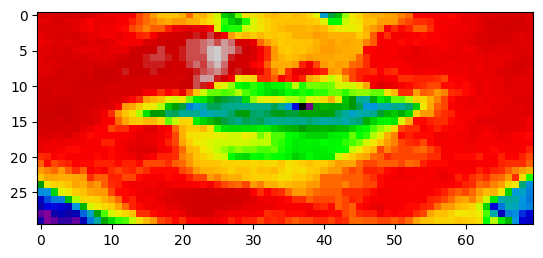

In [187]:
import matplotlib.pyplot as plt

one_frame = test_vid[21]
plt.imshow(first_frame, cmap='nipy_spectral')

In [201]:
def predict_video(model, video_frames):
    # Assuming `video_frames` is your input data # Ensure this is correctly implemented
    video_frames_batch = np.expand_dims(video_frames, axis=0) 

    # Get predictions
    prediction = model.predict(video_frames_batch)

    # The sequence length should match the batch size of 'prediction'
    sequence_length = [len(video_frames)]  # Replace this with the correct sequence length for your data

    # Decode the predictions
    decoded_prediction = tf.keras.backend.ctc_decode(prediction, sequence_length, greedy=False)[0][0].numpy()
    predicted_text = tf.strings.reduce_join(num_to_char(decoded_prediction)).numpy().decode('utf-8')
    return predicted_text

predicted_text = predict_video(model, test_vid)  # Replace 'test_vid' with your video data
print(predicted_text)

1/1 [==============================] - 0s 187ms/step
bin gren in n nin gon by 


In [195]:
print(type(predicted_text))

<class 'str'>


In [165]:
sen_02

'bin day is on tuesday'

### 'praazn'

In [148]:
import pandas as pd

df = pd.read_csv('all_matches.csv')

In [154]:
df[df['Unnamed: 0'] == 'praazn']

,Unnamed: 0,speaker_align,speaker_vid
7689,praazn,s26,s27
